In [18]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import re
import datetime

from nltk.corpus import stopwords
en_stop = set(stopwords.words('english'))

#from stop_words import get_stop_words #https://github.com/Alir3z4/stop-words/blob/master/english.txt
#en_stop = get_stop_words('en')



In [2]:
#If you get any errors with the above imports related to NLTK, please remove the # and execute the following lines
#See http://www.nltk.org/data.html for more details

#import nltk
#nltk.download(["averaged_perceptron_tagger","universal_tagset","ptb","punkt","stopwords","twitter_samples"])

In [3]:
#query looking for all mentions around the candidates and election.
#1% sample of conversation between 19 September until 30 Ocotober.
dfMentions=pd.read_csv("US_Presidential_Election2.csv", skiprows=6)
dfMentions.columns = [c.replace(' ', '_').lower() for c in dfMentions.columns]
dfMentions["datetime"]=pd.to_datetime(dfMentions["date"],format="%Y-%m-%d %H:%M:%S")
dfMentions["date_only"]=dfMentions["datetime"].dt.date


#print(dfMentions.head)

#Print the column/field names
print(list(dfMentions))

/home/shale/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (69,77,85,101) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['query_id', 'query_name', 'date', 'title', 'snippet', 'url', 'domain', 'sentiment', 'page_type', 'language', 'country_code', 'continent_code', 'continent', 'country', 'state_code', 'county_code', 'city_code', 'notes', 'account_type', 'assignment', 'author', 'author_city', 'author_city_code', 'author_continent', 'author_continent_code', 'author_country', 'author_country_code', 'author_county', 'author_county_code', 'author_location', 'author_state', 'author_state_code', 'avatar', 'average_pages_per_visitor', 'average_visits_per_visitor', 'backlinks', 'blog_comments', 'candidates_-_donald_trump', 'candidates_-_hillary_clinton', 'category_details', 'checked', 'city', 'content_-_rts', 'county', 'display_urls', 'engagement_score', 'expanded_urls', 'facebook_author_id', 'facebook_comments', 'facebook_likes', 'facebook_role', 'facebook_shares', 'facebook_subtype', 'forum_posts', 'forum_views', 'full_name', 'gender', 'impact', 'impressions', 'instagram_comments', 'instagram_followers', 'insta

In [4]:
#print(dfMentions[["Page Type","Pro candidate hashtags - Pro Clinton","Snippet","Author Country","State"]].head)

print("--Account Types--")
print(dfMentions["account_type"].value_counts())
print()

print("Pro Clinton: {}".format(dfMentions["pro_candidate_hashtags_-_pro_clinton"].count()))
print("Pro Trump: {}".format(dfMentions["pro_candidate_hashtags_-_pro_trump"].count()))
print()

print("--Page Types--")
print(dfMentions.page_type.value_counts())
print()

print("--Language--")
print(dfMentions.language.value_counts())
print()


--Account Types--
individual        41693
organisational     3630
Name: account_type, dtype: int64

Pro Clinton: 625
Pro Trump: 1827

--Page Types--
facebook     69786
twitter      45868
news          1131
forum          470
general        449
blog           332
video          181
instagram       22
image            4
Name: page_type, dtype: int64

--Language--
en    118243
Name: language, dtype: int64



In [5]:
#Functions for LDA Topics

removewords = set(['rt','com','quot', 'tweet', 'page', 'post', 'thread', 'amp', 'get', 'got', 'can', 'know', 'feel', 'just', 'realli', 'think', 'like', 'one'])
p_stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')

#
def clean_text(doc, stem=True):
    doc_tokens2 = []
    if pd.notnull(doc):
        doc = doc.lower()
        doc = re.sub(r"(http[s]?|www)\S+", "", doc)
        doc_tokens = tokenizer.tokenize(doc)
        for word in doc_tokens:
            if (not word in removewords) and (not word in en_stop) and len(word)>1:
                if stem:
                    stem=p_stemmer.stem(word)
                    doc_tokens2.append(stem)
                else:
                    doc_tokens2.append(word)
    return doc_tokens2



In [6]:

#A list of lists: each list represents the stemmed and tokenized words from each item/snipept

#.sample(n) will sample n rows randomly from the data.frame
#This will greatly speed up your execution time and is good for playing around with things
#Remove this portion to run on the full data.frame

dfMentionsSample=dfMentions.sample(10000)
docs=dfMentionsSample["snippet"].map(clean_text)
#docs=dfMentions["snippet"].map(clean_text)





In [7]:
#Tokens is a list of all unique tokens in any doc in docs
tokens=sum(docs, [])
#Assigns unique integer ID to each unique token while collecting word counts and relevant stats.        
dictionary = corpora.Dictionary([tokens])
#Converts dictionary to bag of words. Corpus is a list of vectors equal to the number of documents; in each document vector is a series of tuples (term ID, term frequency). Corpus is a document-term matrix.
corpus = [dictionary.doc2bow(text) for text in docs]


In [8]:
#Most frequent words overall

fdist = FreqDist(tokens)
top_ten = fdist.most_common(10)

print(top_ten)


[('trump', 6354), ('hillari', 4678), ('clinton', 4275), ('donald', 4240), ('presid', 1746), ('twitter', 1682), ('debat', 1591), ('pic', 1350), ('vote', 1262), ('realdonaldtrump', 1096)]


In [9]:

NUMBER_TOPICS=25
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=NUMBER_TOPICS, id2word = dictionary, passes=25)
top_topics = ldamodel.show_topics(num_topics=NUMBER_TOPICS, num_words=15)


In [10]:
#Top words in each automatically detected topic

print("******************")
for topic in top_topics:
    print("******************")
    print(topic)

******************
******************
(0, '0.164*hillari + 0.164*clinton + 0.019*lie + 0.013*bill + 0.011*fact + 0.011*email + 0.009*vote + 0.009*go + 0.008*women + 0.007*two + 0.007*truth + 0.006*support + 0.006*corrupt + 0.006*crook + 0.006*say')
******************
(1, '0.044*trump + 0.025*donald + 0.024*endors + 0.021*cruz + 0.016*ted + 0.013*realdonaldtrump + 0.010*militari + 0.009*donaldtrump + 0.009*support + 0.009*yet + 0.009*veteran + 0.009*facebook + 0.008*nevertrump + 0.008*putin + 0.007*hundr')
******************
(2, '0.041*trump + 0.040*donald + 0.025*refuge + 0.021*skittl + 0.019*jr + 0.014*compar + 0.014*syrian + 0.009*made + 0.008*wikileak + 0.008*world + 0.008*comment + 0.008*us + 0.007*rest + 0.007*son + 0.007*report')
******************
(3, '0.025*vote + 0.025*hillari + 0.022*clinton + 0.015*novemb + 0.014*us + 0.010*class + 0.010*king + 0.009*fight + 0.009*russia + 0.009*compani + 0.009*anoth + 0.009*endors + 0.009*newsweek + 0.008*friend + 0.008*reason')
***********

In [27]:
#Topic loadings per document
topics = range(0, NUMBER_TOPICS)
topic_loadings = []

def get_loadings(doc):
    doc_loadings = [0]*NUMBER_TOPICS #A list of zeros to start
    doc_topics = ldamodel.get_document_topics(dictionary.doc2bow(clean_text(doc)))
    for topic, loading in doc_topics:
        doc_loadings[topic]=loading #Update the value for topic from 0 to whatever was returned in the tuple
    return doc_loadings

#Convert topic_loadings into a pandas dataframe
topic_loadings = dfMentionsSample.snippet.map(get_loadings)
topic_loadings = pd.DataFrame(list(topic_loadings), columns=["Topic {}".format(x) for x in range(0, NUMBER_TOPICS)]) 
print(topic_loadings.shape) #Number of rows, number of columns.
print(topic_loadings.tail()) #Last five rows.
topic_loadings["date_only"] = dfMentionsSample.date_only.values

(10000, 25)
       Topic 0   Topic 1  Topic 2   Topic 3   Topic 4   Topic 5   Topic 6  \
9995  0.109623  0.036307      0.0  0.236504  0.000000  0.040299  0.042634   
9996  0.000000  0.000000      0.0  0.000000  0.054039  0.000000  0.058895   
9997  0.000000  0.000000      0.0  0.000000  0.000000  0.000000  0.000000   
9998  0.383625  0.000000      0.0  0.000000  0.000000  0.000000  0.000000   
9999  0.000000  0.000000      0.0  0.000000  0.000000  0.000000  0.000000   

      Topic 7   Topic 8  Topic 9    ...     Topic 15  Topic 16  Topic 17  \
9995      0.0  0.000000      0.0    ...     0.045578  0.000000       0.0   
9996      0.0  0.186847      0.0    ...     0.229257  0.107264       0.0   
9997      0.0  0.000000      0.0    ...     0.000000  0.000000       0.0   
9998      0.0  0.357690      0.0    ...     0.000000  0.000000       0.0   
9999      0.0  0.000000      0.0    ...     0.000000  0.000000       0.0   

      Topic 18  Topic 19  Topic 20  Topic 21  Topic 22  Topic 23  To

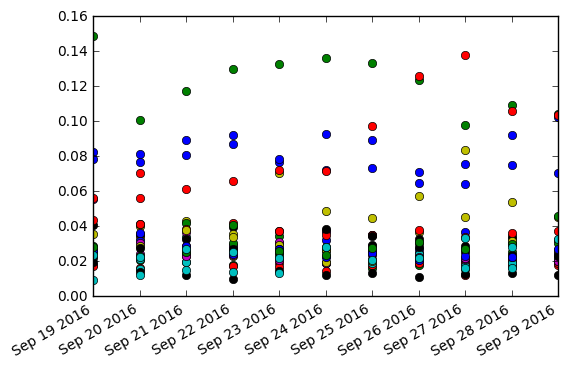

In [30]:
#Topic loadings over time
topics_bydate=topic_loadings.groupby("date_only",as_index=False).sum()
topics_bydate_cnt=topic_loadings.groupby("date_only",as_index=False).count()

fig, ax = plt.subplots()
for i in range(0,NUMBER_TOPICS):
    percent=topics_bydate["Topic {}".format(i)]/topics_bydate_cnt["Topic {}".format(i)]
    ax.plot_date(topics_bydate.date_only,percent, label='Topic {}'.format(i))

fig.autofmt_xdate()
#ax.set_xlim([datetime.date(2016, 9, 19), datetime.date(2016, 9, 30)])
plt.show()

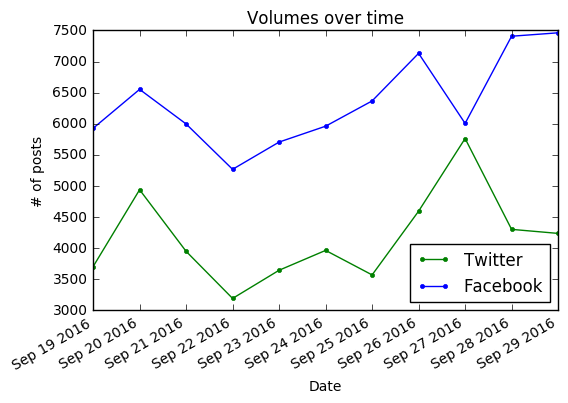

In [13]:
#Volumes per platform
volumes=dfMentions.groupby(["date_only","page_type"],as_index=False).count()

tw_volumes=volumes[volumes.page_type=="twitter"]
fb_volumes=volumes[volumes.page_type=="facebook"]

fig, ax = plt.subplots()
ax.plot_date(tw_volumes.date_only,tw_volumes.query_id, 'g.-', label='Twitter')
ax.plot_date(fb_volumes.date_only,fb_volumes.query_id, 'b.-', label='Facebook')
fig.autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("# of posts")
plt.legend(loc='best')
plt.title("Volumes over time")
plt.show()

#Day of week / time of day for posting
#dfMentions["Date"].dt.dayofweek.head()



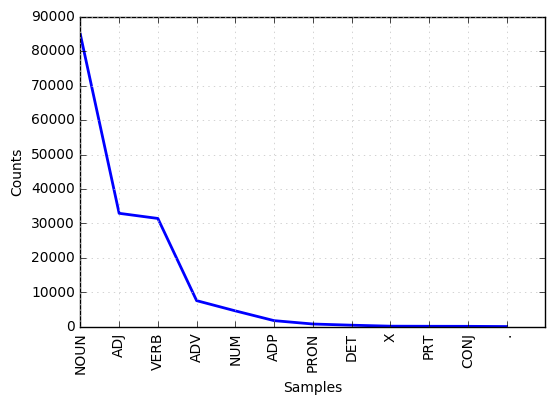

 NOUN   ADJ  VERB   ADV   NUM   ADP  PRON   DET     X   PRT  CONJ     . 
84847 32936 31440  7580  4606  1774   796   453   166   137   122    59 
None


In [14]:
#Part-of-speech tagging and distributions
#pos=docs.map(nltk.pos_tag)

docs=dfMentionsSample["snippet"].map(lambda x: clean_text(x,stem=False))
pos=docs.map(lambda x : nltk.pos_tag(x,tagset="universal"))

#pos is a list of lists. pos_flat is just a list
pos_flat=[item for sublist in pos.tolist() for item in sublist]

pos_freq = nltk.FreqDist(tag for (word, tag) in pos_flat)
pos_freq.most_common()
pos_freq.plot()
print(pos_freq.tabulate())


In [15]:
#Machine learning approach to pro-Trump / pro-Clinton classification



